# Analysis


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from collections import OrderedDict

from skimage import io
from skimage.measure import regionprops
from skimage.measure import find_contours
from skimage.segmentation import join_segmentations

from filters import threshold, binarize
from clustering import nearest_region_clustering
from measure import region_selection, region_labeling
from segmentation import select_targets, clear_borders

%matplotlib inline

plt.rcParams['font.size'] = 16
plt.rcParams['axes.facecolor'] = 'black'

io.use_plugin('tifffile')

In [2]:
def histograms(image):
    
    fig, ax = plt.subplots(ncols=2, figsize=(12, 6))
    fig.suptitle('Max: {} Min: {} Shape: {}'.format(np.max(image),
                                                    np.min(image),
                                                    np.shape(image)))

    ax[0].hist(image.flatten(), bins=image.max());
    ax[0].set_title('Image histogram');
    ax[1].hist(image.flatten(), bins=image.max(), log=True);
    ax[1].set_title('Log-scale image histogram');

    plt.tight_layout()
    fig.subplots_adjust(top=0.80)
    
    return plt

In [3]:
def try_thresholds(image):
    
    colors = ['w', 'r', 'b']
    
    thresholds = {
        'otsu': threshold(image, algorithm='otsu'), 
        'yen': threshold(image, algorithm='yen'),
        'li': threshold(image, algorithm='li')
    }

    plt.figure(figsize=(10, 6))
    plt.title('Image thresholding')
    plt.hist(image.flatten(), bins=image.max());
    
    for num, thresh in enumerate(thresholds.values()):
        plt.axvline(x=thresh, color=colors[num])

    legend = plt.legend(
        ['otsu: {}'.format(thresholds['otsu']), 
         'yen: {}'.format(thresholds['yen']), 
         'li: {}'.format(thresholds['li'])]
    )
    
    plt.setp(legend.get_texts(), color='w')
    plt.tight_layout()
    
    return thresholds

In [4]:
def display_region(region_id, labeled, clusters, figsize=(8, 6)):

    region = labeled.copy()

    region[labeled != region_id] = 0

    plt.figure(figsize=figsize)
    plt.imshow(region, interpolation='nearest', cmap=plt.cm.viridis)
    
    for x, y in clusters[region_id]:
        plt.scatter(y, x, color='w')
    
    return plt

## Segmenting the reference image

Load reference image

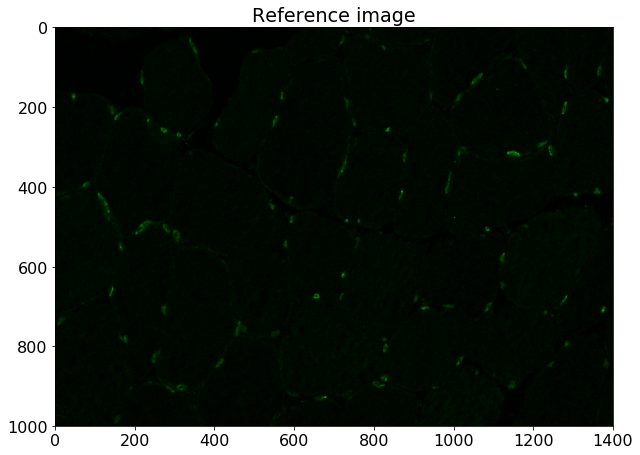

In [5]:
ref_image = io.imread('./../../nih_material/images/train/refr_train.tif')
#ref_image = io.imread('./../../nih_material/images/orig/targets_v2.tif')

plt.figure(figsize=(10, 10))
plt.imshow(ref_image);
plt.title('Reference image');

Display histograms

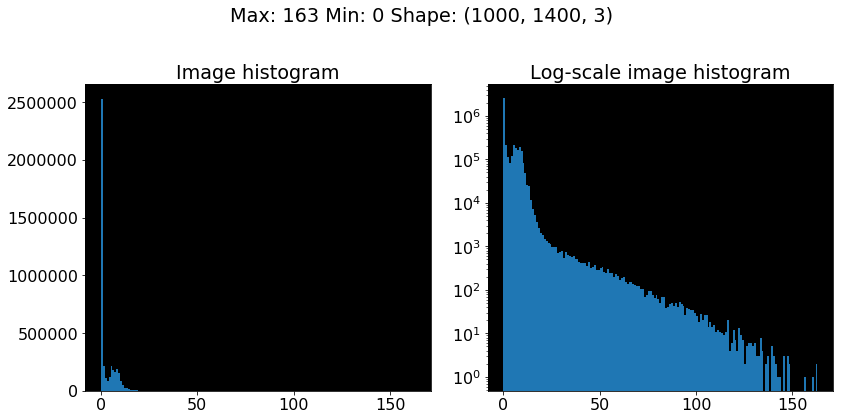

In [6]:
histograms(ref_image);

Comparing thresholding algorithms

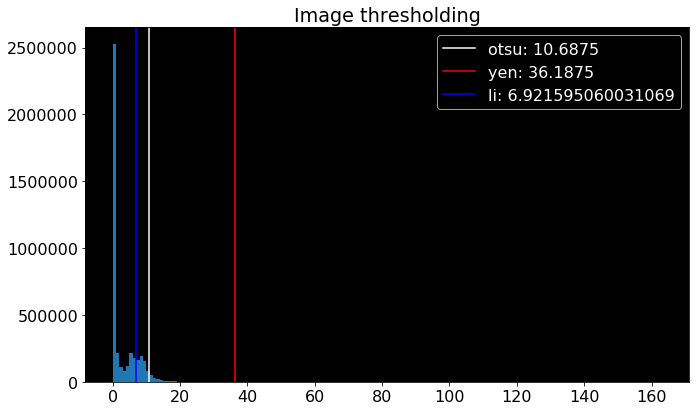

In [7]:
ref_thresholds = try_thresholds(ref_image);

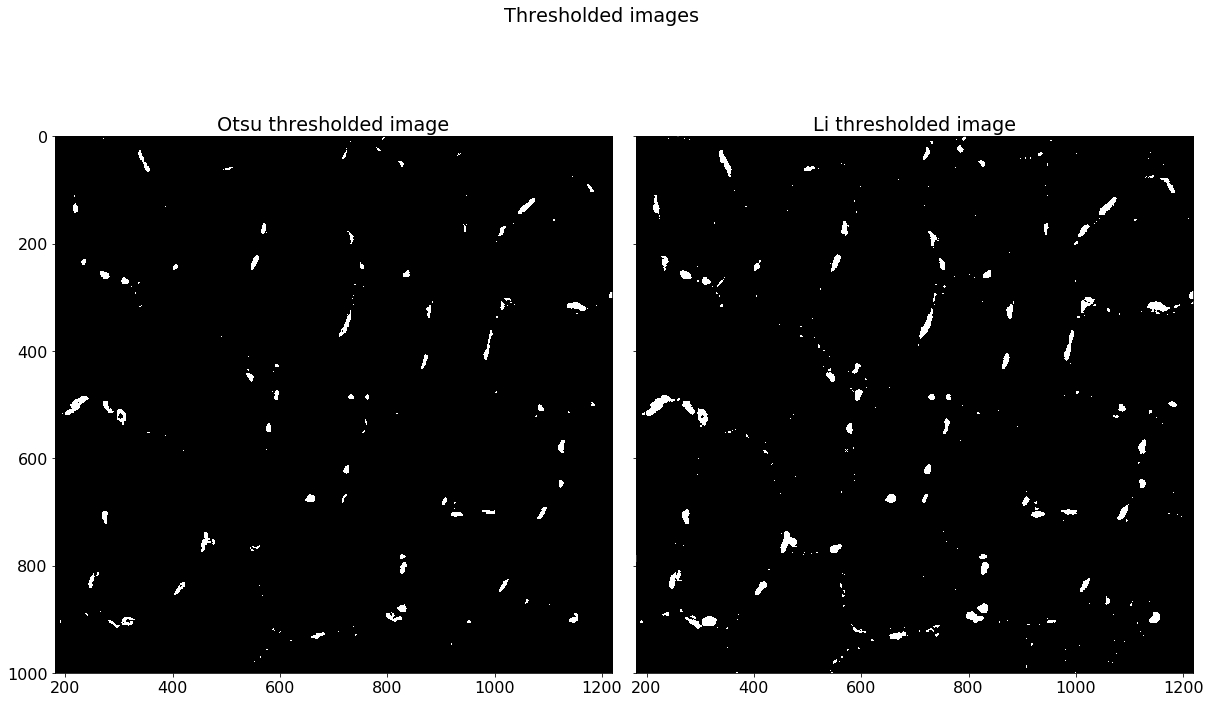

In [8]:
fig, ax = plt.subplots(ncols=2, figsize=(17, 10), sharey=True)
fig.suptitle('Thresholded images')

ax[0].imshow(binarize(ref_image, ref_thresholds['otsu']), cmap=plt.cm.gray);
ax[0].set_title('Otsu thresholded image');
ax[1].imshow(binarize(ref_image, ref_thresholds['li']), cmap=plt.cm.gray);
ax[1].set_title('Li thresholded image');

plt.tight_layout()
fig.subplots_adjust(top=0.80)

It appears to be more noise in *Li* thresholded image.

In [9]:
ref_binary = binarize(ref_image, ref_thresholds['otsu'])

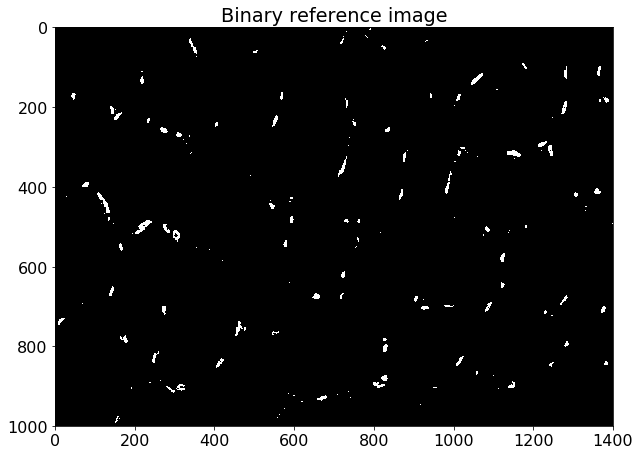

In [10]:
plt.figure(figsize=(10, 10))
plt.imshow(ref_binary, cmap=plt.cm.gray);
plt.title('Binary reference image');

Remove image artifacts with areas less than a specified limit.

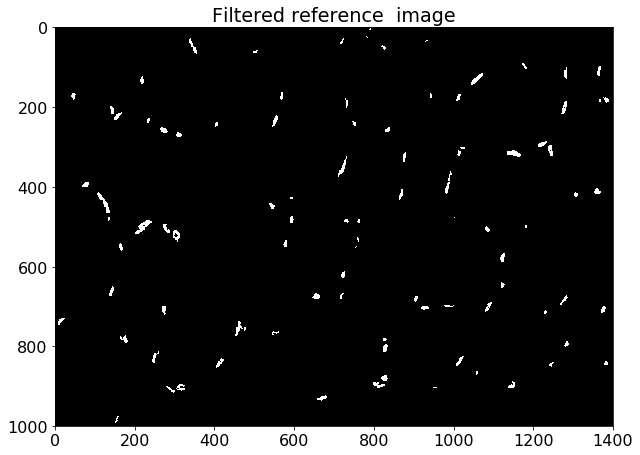

In [11]:
ref_filtered = region_selection(ref_binary, {'min_area': 15})

plt.figure(figsize=(10, 10))
plt.imshow(ref_filtered, cmap=plt.cm.gray);
plt.title('Filtered reference  image');

Compare the binary version of the filtered reference image to the original 

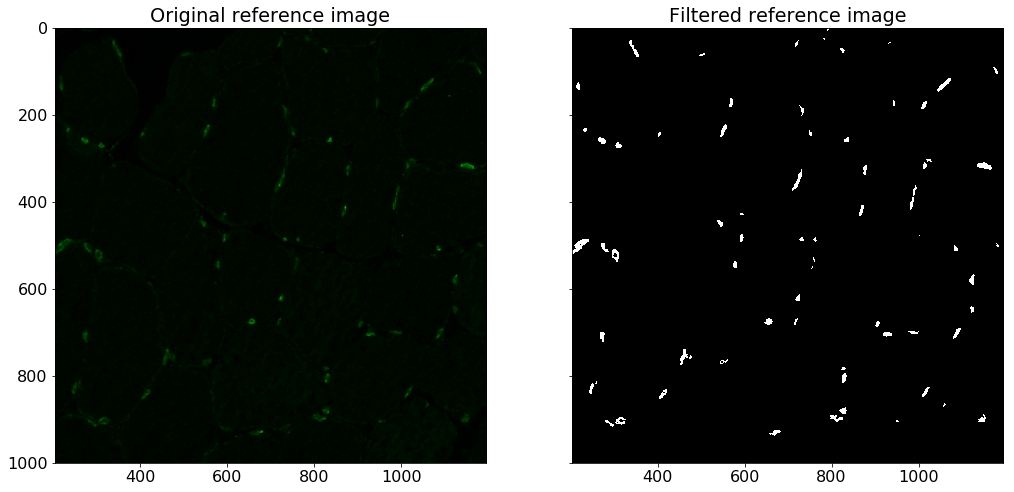

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(17, 8), sharey=True)

ax[0].imshow(ref_image, cmap=plt.cm.gray);
ax[0].set_title('Original reference image');
ax[1].imshow(ref_filtered, cmap=plt.cm.gray)
ax[1].set_title('Filtered reference image');

## Segmenting the samples image

Load samples image

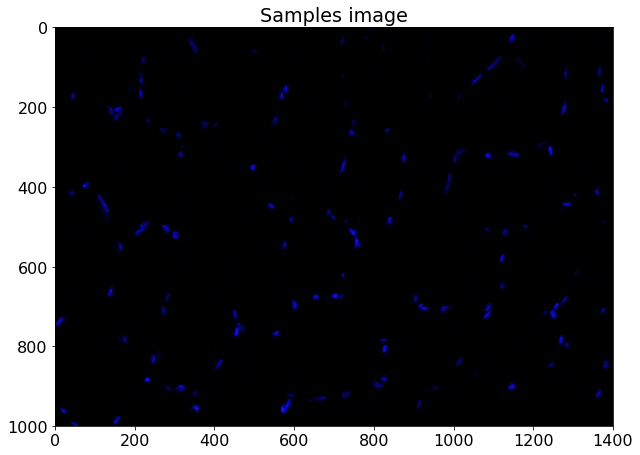

In [13]:
samples_image = io.imread('./../../nih_material/images/train/samples_train.tif')
#samples_image = io.imread('./../../nih_material/images/orig/samples_v2.tif')

plt.figure(figsize=(10, 10))
plt.imshow(samples_image);
plt.title('Samples image');

Display histograms

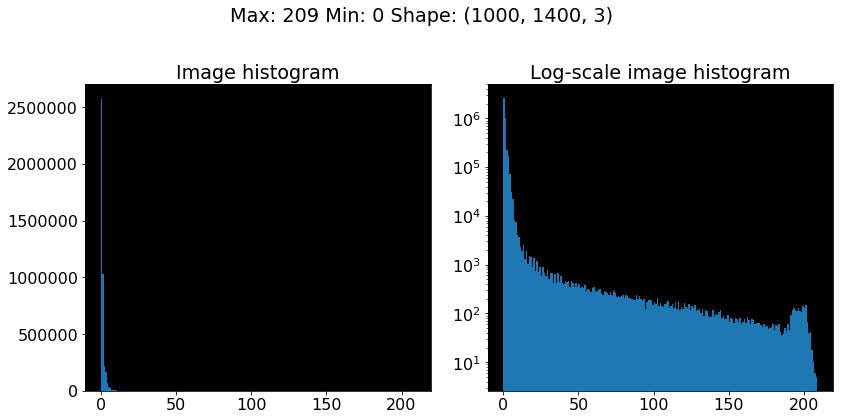

In [14]:
histograms(samples_image);

Comparing thresholding algorithms


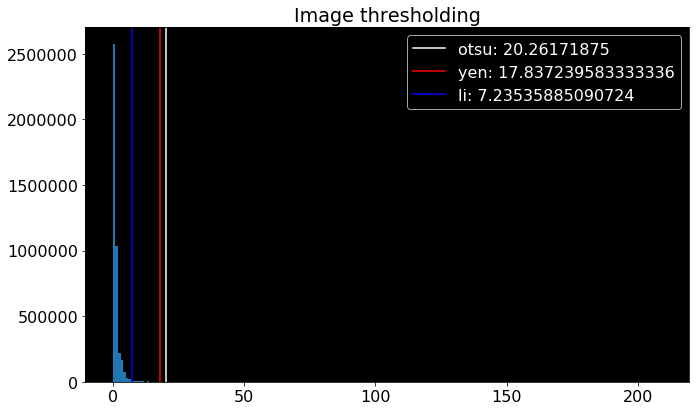

In [15]:
samples_thresholds = try_thresholds(samples_image);

Inspect thresholded images

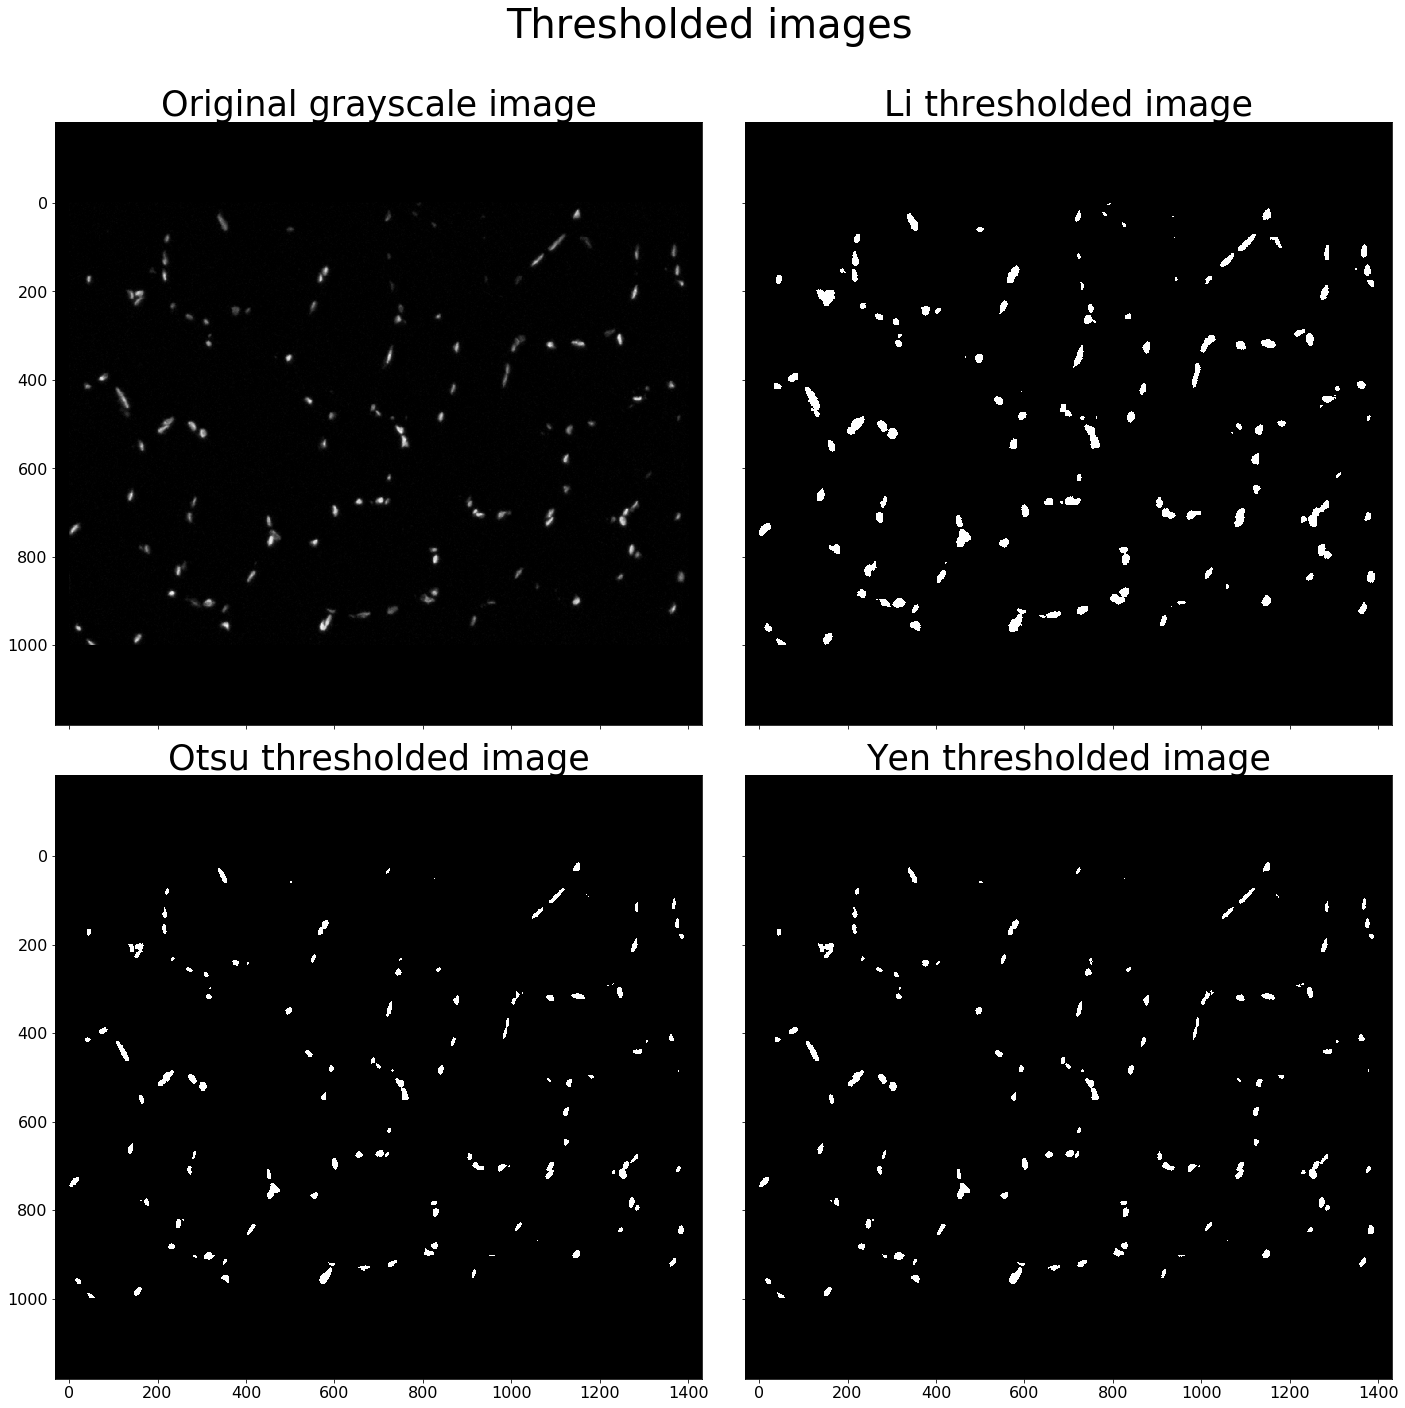

In [16]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(20, 20), sharex=True, sharey=True
)

fig.suptitle('Thresholded images', fontsize=40)

ax[0, 0].imshow(np.mean(samples_image, axis=2), cmap=plt.cm.gray);
ax[0, 0].set_title('Original grayscale image', fontsize=35);

ax[0, 1].imshow(binarize(samples_image, samples_thresholds['li']),
                cmap=plt.cm.gray);
ax[0, 1].set_title('Li thresholded image', fontsize=35);

ax[1, 0].imshow(binarize(samples_image, samples_thresholds['otsu']), 
                cmap=plt.cm.gray);
ax[1, 0].set_title('Otsu thresholded image', fontsize=35);

ax[1, 1].imshow(binarize(samples_image, samples_thresholds['yen']), 
                cmap=plt.cm.gray);
ax[1, 1].set_title('Yen thresholded image', fontsize=35);

plt.tight_layout()
fig.subplots_adjust(top=0.90)

Image segmentation and binarization by thresholding

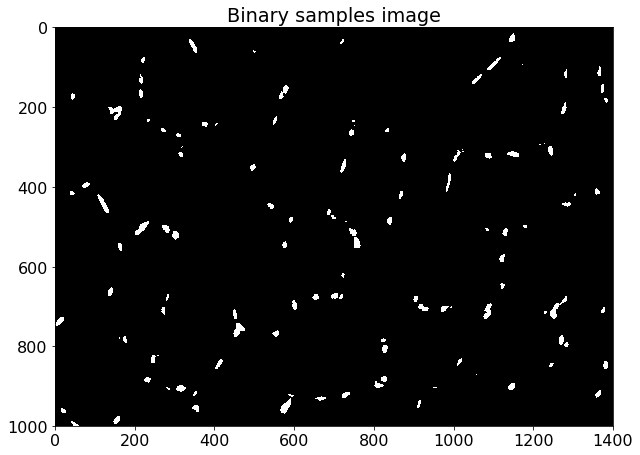

In [17]:
samples_binary = binarize(samples_image, thresh=samples_thresholds['otsu'])

plt.figure(figsize=(10, 10))
plt.imshow(samples_binary, cmap=plt.cm.gray);
plt.title('Binary samples image');

Remove image artifacts different from specifications

In [18]:
samples_filtered = region_selection(samples_binary, {'min_area': 10})

Comparing to the original samples image

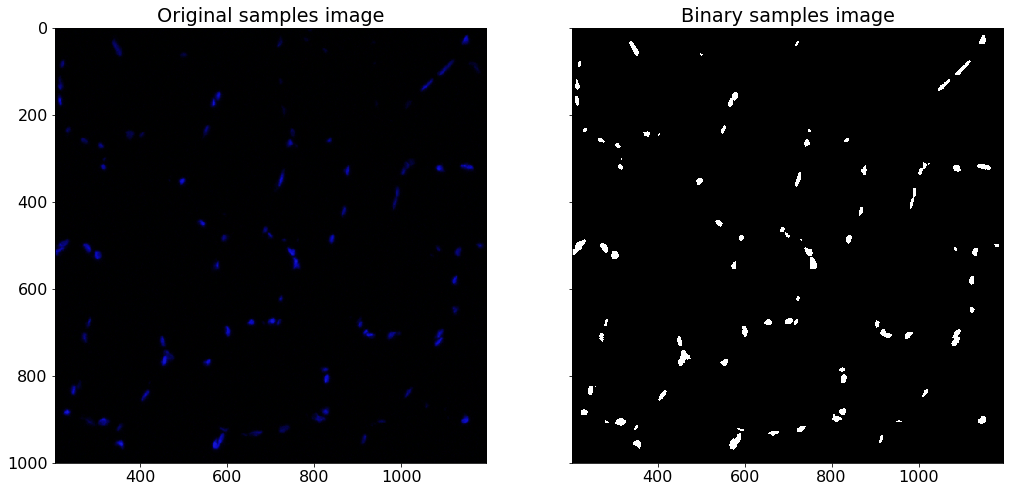

In [19]:
fig, ax = plt.subplots(ncols=2, figsize=(17, 8), sharey=True)

ax[0].imshow(samples_image, cmap=plt.cm.gray);
ax[0].set_title('Original samples image');
ax[1].imshow(samples_filtered, cmap=plt.cm.gray)
ax[1].set_title('Binary samples image');

## Segmenting the clusters image 

Load image

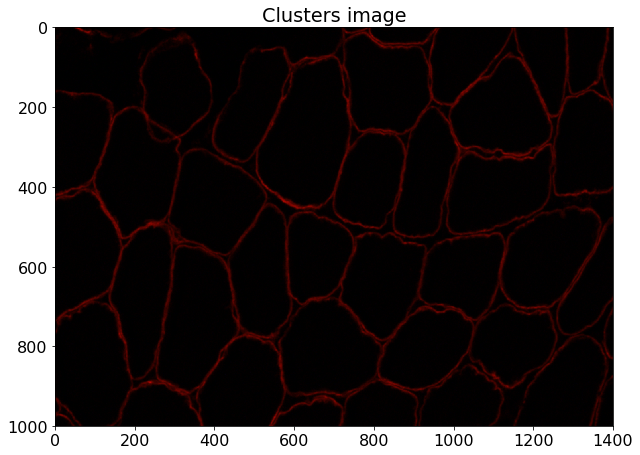

In [20]:
clusters_image = io.imread('./../../nih_material/images/train/clusters_train.tif')
#clusters = io.imread('./../../nih_material/images/orig/membrane_v2.tif')

plt.figure(figsize=(10, 10))
plt.imshow(clusters_image);
plt.title('Clusters image');

Display histograms

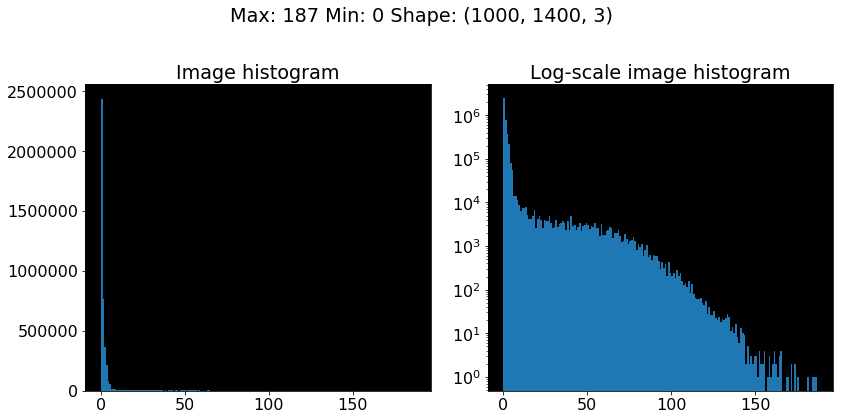

In [21]:
histograms(clusters_image);

Comparing thresholding algorithms

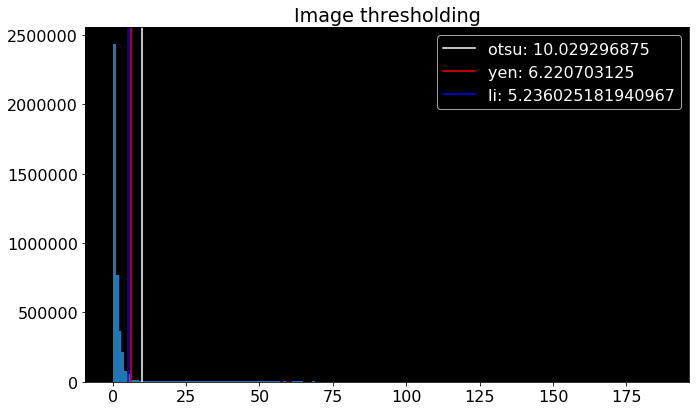

In [22]:
clusters_thresholds = try_thresholds(clusters_image);

Inspecting thresholded images

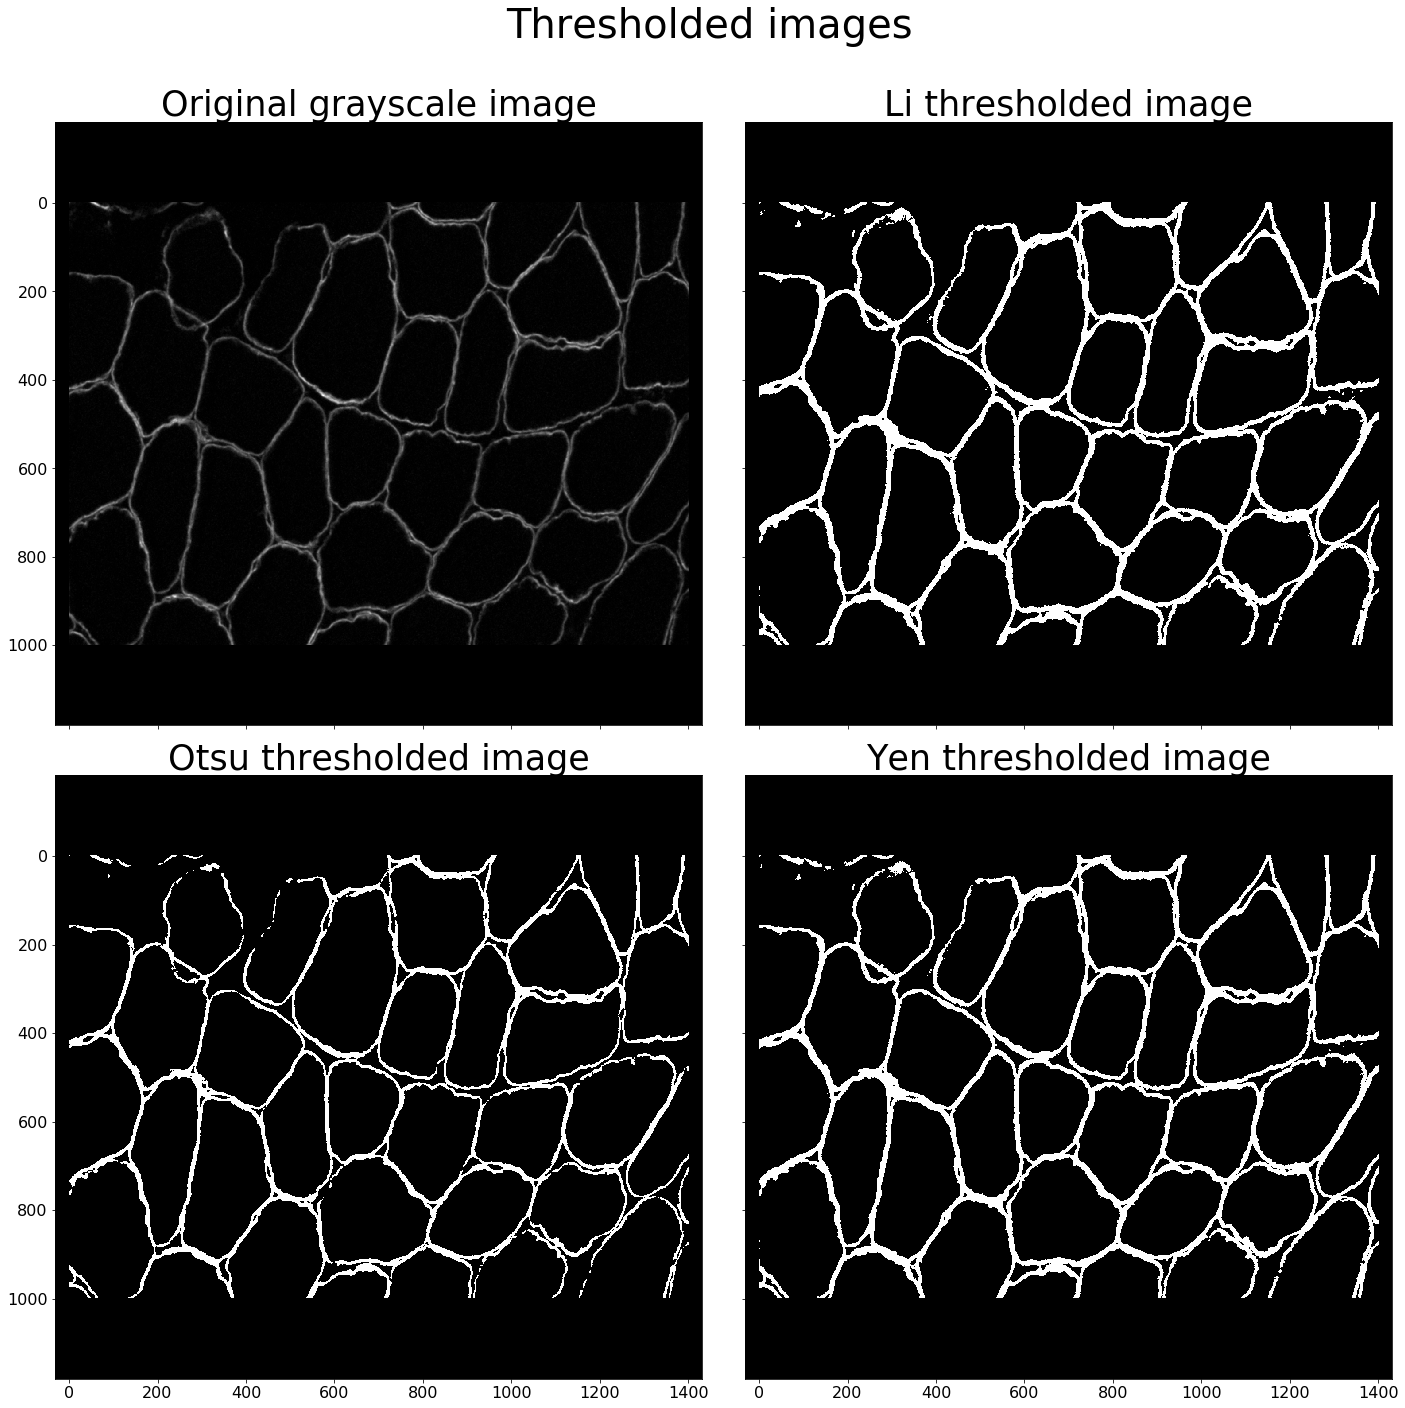

In [23]:
fig, ax = plt.subplots(
    nrows=2, ncols=2, figsize=(20, 20), sharex=True, sharey=True
)

fig.suptitle('Thresholded images', fontsize=40)

ax[0, 0].imshow(np.mean(clusters_image, axis=2), cmap=plt.cm.gray);
ax[0, 0].set_title('Original grayscale image', fontsize=35);

ax[0, 1].imshow(binarize(clusters_image, clusters_thresholds['li']),
                cmap=plt.cm.gray);
ax[0, 1].set_title('Li thresholded image', fontsize=35);

ax[1, 0].imshow(binarize(clusters_image, clusters_thresholds['otsu']), 
                cmap=plt.cm.gray);
ax[1, 0].set_title('Otsu thresholded image', fontsize=35);

ax[1, 1].imshow(binarize(clusters_image, clusters_thresholds['yen']), 
                cmap=plt.cm.gray);
ax[1, 1].set_title('Yen thresholded image', fontsize=35);

plt.tight_layout()
fig.subplots_adjust(top=0.90)

Image segmentation and binarization by thresholding

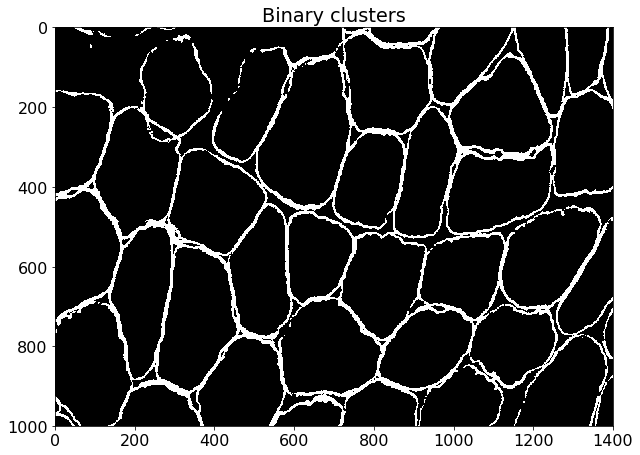

In [24]:
clusters_binary = binarize(clusters_image, clusters_thresholds['otsu'])

plt.figure(figsize=(10, 10))
plt.imshow(clusters_binary, cmap=plt.cm.gray);
plt.title('Binary clusters');

Comparing the binary clusters image to the original


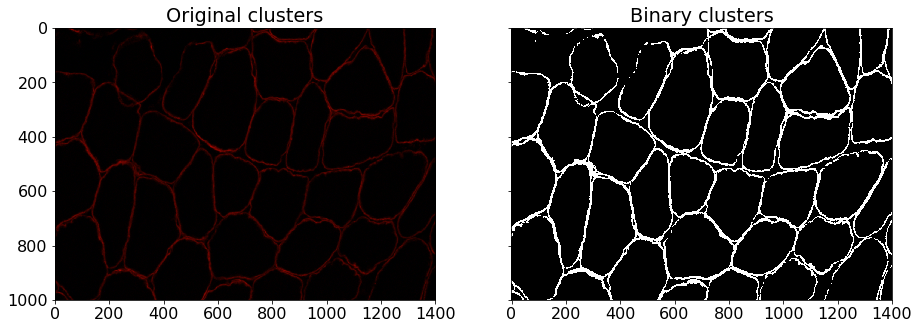

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(clusters_image, cmap=plt.cm.gray);
ax[0].set_title('Original clusters');
ax[1].imshow(clusters_binary, cmap=plt.cm.gray)
ax[1].set_title('Binary clusters');

Clear the image borders and broken membranes in the outer region

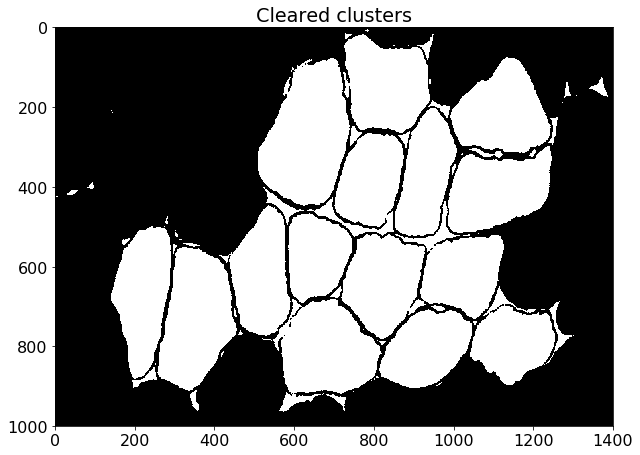

In [26]:
clusters_cleared = clear_borders(clusters_binary)

plt.figure(figsize=(10, 10))
plt.imshow(clusters_cleared, cmap=plt.cm.gray);
plt.title('Cleared clusters');

Remove image artifacts with areas less than a specified limit.

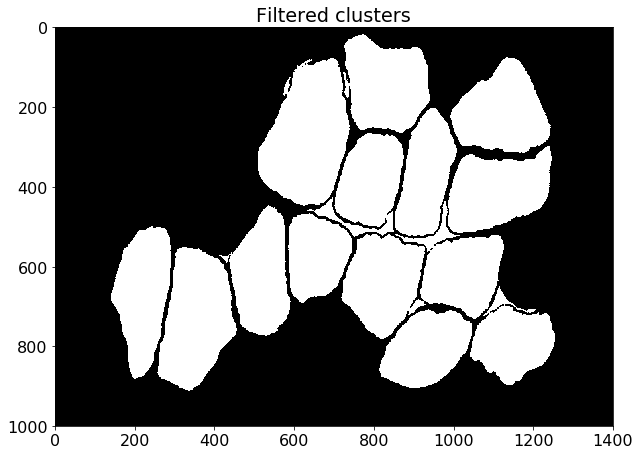

In [27]:
blob_criteria = {
    'min_area': 15000, 'max_area': 400000, 
    'min_eccent': 0.2, 'max_eccent': 0.98, 
    'min_solidity': 0.65, 'max_solidity': 0.98
}
clusters_filtered = region_selection(clusters_cleared, blob_criteria)

plt.figure(figsize=(10, 10))
plt.imshow(clusters_filtered, cmap=plt.cm.gray);
plt.title('Filtered clusters');

Compare to cleared cluster image

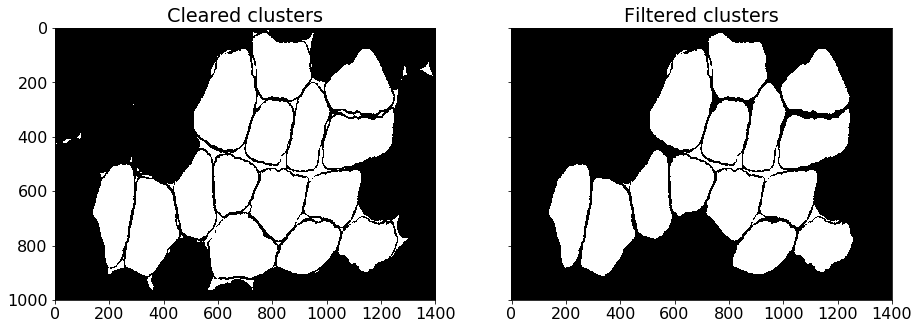

In [28]:
fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(clusters_cleared, cmap=plt.cm.gray);
ax[0].set_title('Cleared clusters');
ax[1].imshow(clusters_filtered, cmap=plt.cm.gray)
ax[1].set_title('Filtered clusters');

## Target regions filtering

Compute an image by comparing the segmented regions in the reference and samples image while retaining only the overlapping regions.

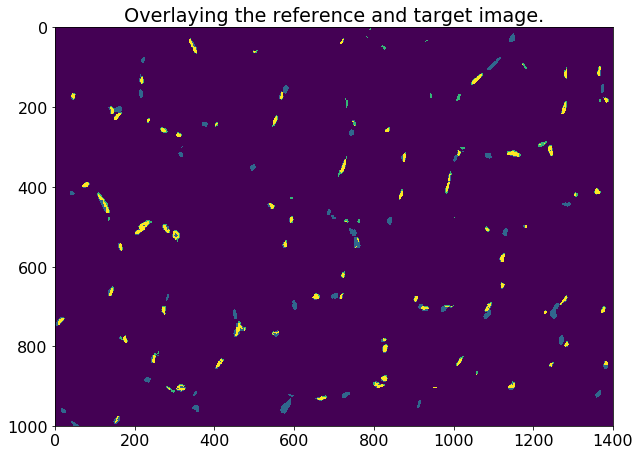

In [29]:
masked = join_segmentations(ref_filtered, samples_binary,)
masks = np.unique(masked)
classes = np.linspace(np.min(ref_filtered), np.max(ref_binary), masks.size)

overlayed = np.zeros_like(ref_filtered, dtype=int)

for num, mask in enumerate(masks):
    overlayed[masked == mask] = int(classes[num])

plt.figure(figsize=(10, 10))
plt.imshow(overlayed, cmap=plt.cm.viridis);
plt.title('Overlaying the reference and target image.');

where:
* purple = background
* teal = samples regions
* green = reference regions
* yellow = samples + reference regions

Computing the image containing only the yellow regions as image target regions

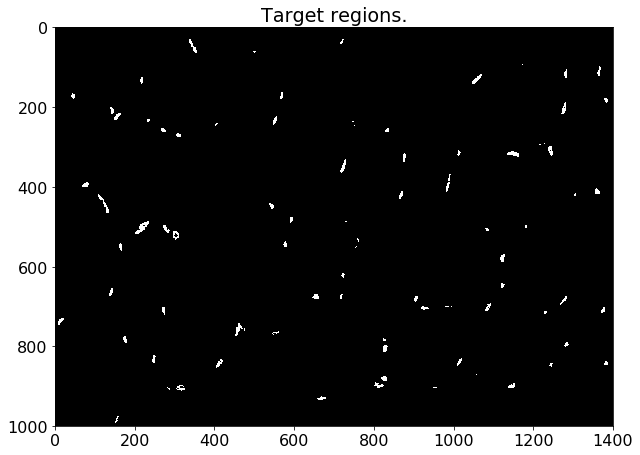

In [30]:
targets = select_targets(ref_filtered, samples_binary)

plt.figure(figsize=(10, 10))
plt.imshow(targets, cmap=plt.cm.gray);
plt.title('Target regions.');

Comparing to the overlayed image

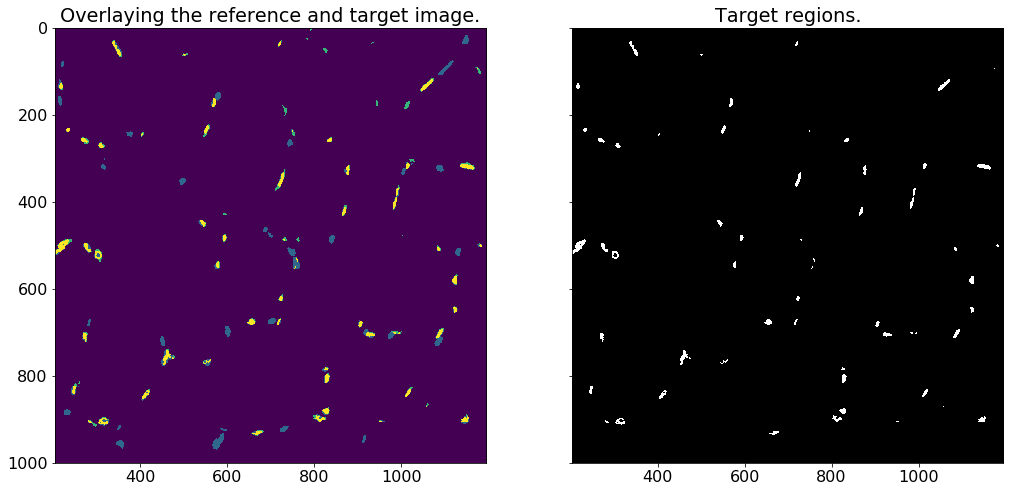

In [31]:
fig, ax = plt.subplots(ncols=2, figsize=(17, 8), sharey=True)

ax[0].imshow(overlayed, cmap=plt.cm.viridis);
ax[0].set_title('Overlaying the reference and target image.');
ax[1].imshow(targets , cmap=plt.cm.gray)
ax[1].set_title('Target regions.');

The regions of the binary image represents the target regions that will be assigned to clusters.

## Clustering

Labelling the cluster and target images

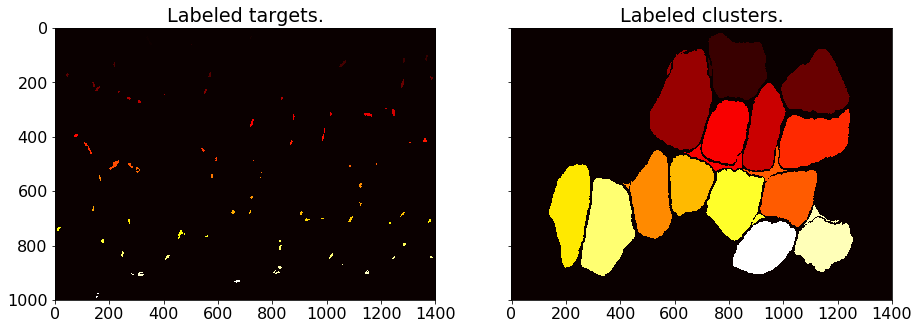

In [32]:
targets_labeled = region_labeling(targets)
clusters_labeled = region_labeling(clusters_filtered)

fig, ax = plt.subplots(ncols=2, figsize=(15, 5), sharey=True)

ax[0].imshow(targets_labeled, cmap=plt.cm.hot);
ax[0].set_title('Labeled targets.');
ax[1].imshow(clusters_labeled , cmap=plt.cm.hot)
ax[1].set_title('Labeled clusters.');

Computing target region centroids and cluster region coordinates

In [33]:
target_props = regionprops(targets_labeled)
cluster_props = regionprops(clusters_labeled)

target_centroids = OrderedDict()
for num, props in enumerate(target_props):
    target_id = num + 1
    target_centroids[target_id] = (props.centroid)
    
region_coords = OrderedDict()  
for num, props in enumerate(cluster_props):
    region_id = num + 1
    region_coords[region_id] = props.coords

Visualizing the centroids overlaying the target regions

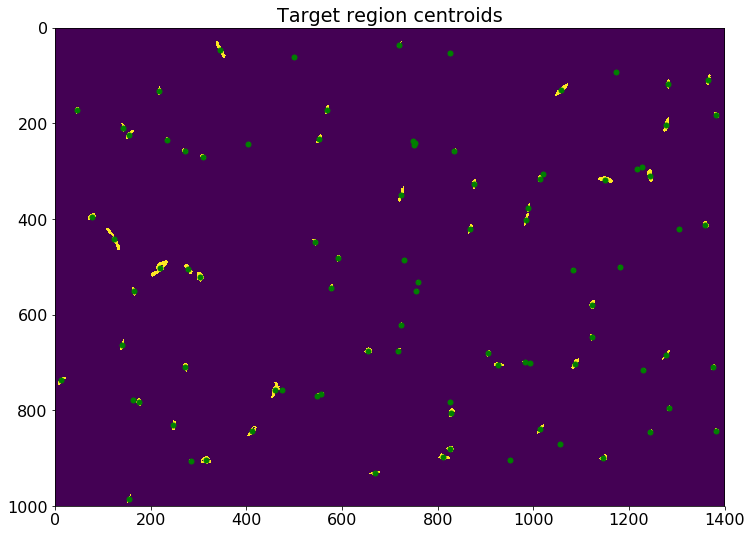

In [34]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(targets, interpolation='nearest', cmap=plt.cm.viridis)

for centroid in target_centroids.values():
    x0, y0 = centroid
    ax.plot(y0, x0, 'g.', markersize=10)
    
ax.set_title('Target region centroids');

Displaying the centroids of each target region in addition to labeled cluster regions

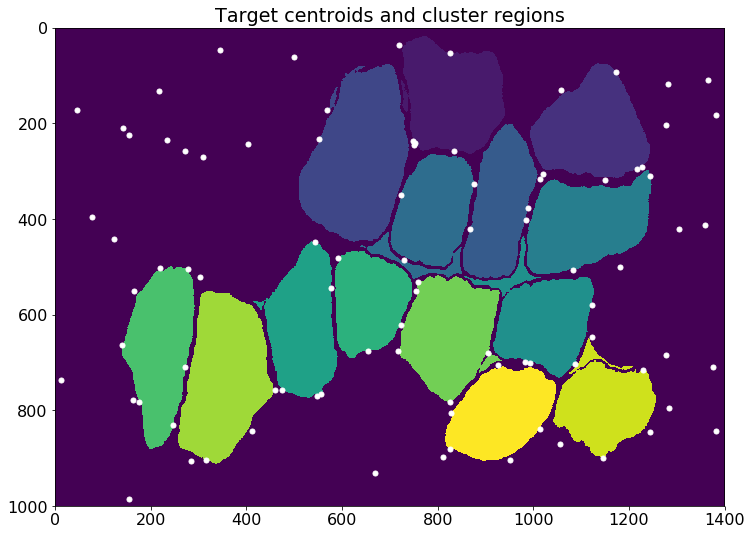

In [35]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clusters_labeled, interpolation='nearest', cmap=plt.cm.viridis)

for centroid in target_centroids.values():
    x0, y0 = centroid
    ax.plot(y0, x0, 'w.', markersize=10)
    
ax.set_title('Target centroids and cluster regions');

Target centroid positions overlaying the binary version of the thresholded cluster image.

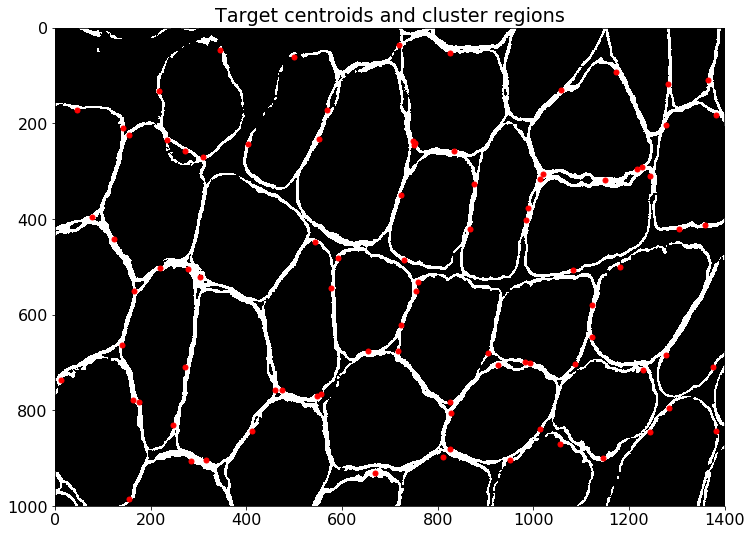

In [36]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clusters_binary, interpolation='nearest', cmap=plt.cm.gray)

for centroid in target_centroids.values():
    x0, y0 = centroid
    ax.plot(y0, x0, 'r.', markersize=10)
    
ax.set_title('Target centroids and cluster regions');

In [37]:
clusters = nearest_region_clustering(target_centroids, region_coords, distance_thresh=15)

Filtering of target values due to distance threshold

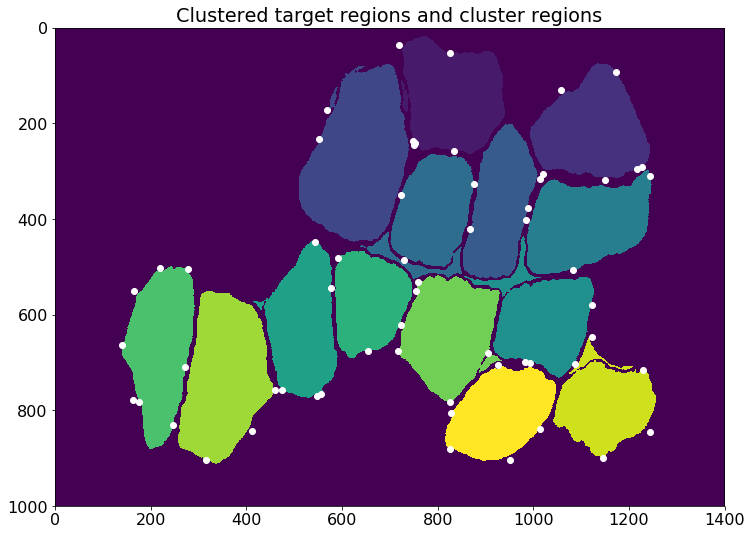

In [38]:
fig, ax = plt.subplots(figsize=(12, 12))
ax.imshow(clusters_labeled, interpolation='nearest', cmap=plt.cm.viridis)

for region_id, centroids in clusters.items():
    if not centroids:
        continue
    else:
        x, y = list(zip(*centroids))
        ax.scatter(y, x, c='w')
        
ax.set_title('Clustered target regions and cluster regions');

The clustering results

In [39]:
#for region_id, centroids in clusters.items():
#    print('Region {}: {} targets'.format(region_id, len(centroids)))

The total number of targets in the image

In [40]:
np.sum([len(centroids) for centroids in clusters.values()])

60

Displaying the targets associated with a specified cluster region

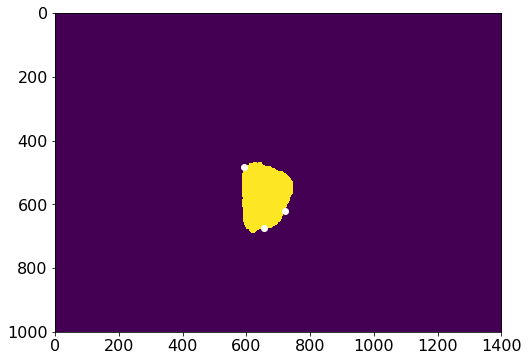

In [41]:
display_region(9, clusters_labeled, clusters, figsize=(8, 6));

In [42]:
# TODO: Make subplots for ech region